1. Hypermaters of some of the algorithms, determine model parameters and hence performance. Where the algos.
are not parametric, they affect the structure of the model and hence performance.
Hence, tuning hyperparameters is necessary to optimze the model performance. Approaches can be classified in
sklearn as - 
  - GridSearch using Cross Validation 
    - **Best practice for model selection using cv based grid search**
  - Randomized search using cross validation
2. Tips for hypermatater tuning. 
  - Using multiple eval. metrics 
  - Composite estimators and parameter spaces
  - Parallelism 
  - Robustness to failure
3. Alternatives to brute force searching when thinking about model selection
  - Model specific CV in sklearn
  - Using Information Criterion 
4. Using Out of Bag estimates as a measure of performance/generalization error  

Reference : https://scikit-learn.org/stable/modules/grid_search.html  

In [51]:
import numpy as np
import sklearn 
from matplotlib import pyplot as plt 
%matplotlib notebook
plt.style.use('bmh')

#### 1.1 GridSearch using Cross Validation  
- This strategy involves searching through and finding an optimal set of hyperparameters for an **estimator** from a **specfied hyperparameter space, by creating estimates of model performance**. 
    - **cross validation strategy**, used to estimate model performance
    - using an **eval. metric**  
- In sklear all parameters specified at the time of constructing an estimator object, is hperparameter and can be
searched this way. Notes:
  - estimaor.get_params()
  - **Some of these params, can have large impact on predictive performance(eval metric) as well as computational
    performance, while others are left at their default values**. Get a finer understanding by reading the estimator
    class' docstring and included literature, before embarking on GridSearch 
  - Some estimators have parameters for which it is as efficient to calculate model performance for single values as 
    for multiple values, so this feature is used in some model specific cv discussed in 3.1

##### Example of grid search CV on breast cancer data set

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import datasets
from sklearn.svm import SVC

In [ ]:
data = datasets.load_breast_cancer()
y = data.target
X = data.data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, 
                                   shuffle = True, random_state = 123,
                                  stratify = y)

In [ ]:
# invoke estimator
svc = SVC()
# Check params of classifier
print(svc.get_params())
# parameter space - list of dictionaries can be specified to form mutiple search spaces, here 2
params_grid = [{'kernel' : ['linear'],
                'C': [1,10,100,1000]
              },
               {'kernel' : ['rbf'],
                'C': [1,10,100,1000],
              'gamma' : [0.001, 0.0001]}
              ]
eval_metrics = ["precision", "recall", "f1" ]
# CV strategy - stratified k fold , specifying shuffle as True
scv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123)

In [ ]:
gs = GridSearchCV(estimator= svc, param_grid= params_grid, 
                  scoring = eval_metrics, cv = scv, refit = 'f1',
                 return_train_score = True)
_ = gs.fit(X_train, y_train)

##### Resulting dictionary can be directly converted to a data frame with by parameter group
- mean of each predictive eval metric across test and train folds
- score of each eval metric on a train and test fold 
- std. deviationof each predictive eval metric across test and train folds
- ranking of parameters based on mean of each eval metric
- same score on computation time for fitting and scoring(generating predictions)

In [ ]:
import pandas as pd
report = pd.DataFrame(gs.cv_results_)
print(report.iloc[:,2:5])
report.to_csv('svc_grid_search.csv')

In [ ]:
# Refit estimator on the full training set
gs.best_estimator_

In [ ]:
# With refit, the object can be used directly to score test data, using the eval_metric chosen for refit
holdout_f1 = gs.score(X_test,y_test)

In [ ]:
idx_best = gs.best_index_
mean_train_f1 = gs.cv_results_['mean_train_f1'][idx_best]
std_train_f1 = gs.cv_results_['std_train_f1'][idx_best]
mean_test_f1 = gs.cv_results_['mean_test_f1'][idx_best]
std_test_f1 = gs.cv_results_['std_test_f1'][idx_best]
#mean_test_f1 == gs.best_score_

In [ ]:
print('Best params :',gs.best_params_ )
print('Best cv f1 test score : {0:.4f} with std : {1:.4f}'.format(mean_test_f1,std_test_f1))
print('Best cv f1 train score : {0:.4f} with std : {1:.4f}'.format(mean_train_f1,std_train_f1))
print('f1 score on holdout set : {0:.4f}'.format(holdout_f1))

#### 1.2 Best practice for model selection using cv based grid search 
- Cross validation is apt for estimating a model's performance. 
- When we tune a model using a simple cross validation method, the performance estimate obtained for the chosen model can turn out to be biased, and has been shown to be optimistically biased for small data sets and complex models. Reason being, performance is chosen as the basis of selection, and so we potentially make optimistic claim about the performance.
- Below papers and cross-validated post recommend, doing a nested cross validation, where inner cv on each fold, choses the best hypermatater model, and generates a score **that gives an unbiased estimate of the performance of this method of model building by choosing best hyperparameter model using cross validation**.
  - https://stats.stackexchange.com/questions/11602/training-with-the-full-dataset-after-cross-validation 
  - Suggestion is also to include a regularization parameter to the evaluation metric for model selection process to avoid overfitting. 
- Recommendation is to do a nested CV to get an unbiasd estimate of performance of model buislding method by way of hypermarameter tuning. Also perform regularization on selection metric to choose model. Finally train on the full data set for operational use.
 - sklearn's demonstration, which is replicated in detail below for understanding is here - https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html#sphx-glr-auto-examples-model-selection-plot-nested-cross-validation-iris-py
 - How to use nested cv then for parameter selection and estimating performance of the method

<img src = "Nested_CV.JPG" style = "width:600px; height:400px;">

#### Proof that the Cross validation method of model building (that is choosing its hyperparameters can give a biased estimate)

In [ ]:
# 1. Load iris data sets 
# 2. Split into train and test 
# 3. Fit an SVM model with rbf kernel, choose hyperparameters using cross validation, mean cv score to be taken 
## as estimate of performance of model building method
# Run this procesure 30 times to get 30 estimates of best scores
# 4. Run a CV inside each fold of a CV iterator, find the best model on the training portion of the outer CV fold, obtain
## the best model, then score on the test set of the outer CV. Generate the score of best model from each inner CV, 
## by scoring it on the tese set of the fold. 
## Mean score across test set of all these folds becomes estimate of the model building process. 
## Repeate this process 30 times, to obtan 30 scores. 
### Compare

In [10]:
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score,make_scorer
from sklearn import datasets
from sklearn.svm import SVC
import numpy as np 

In [88]:
iris = datasets.load_iris()
X = iris.data
y = iris.target 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, 
                                   shuffle = True, random_state = 123,
                                  stratify = y)
param_grid = { 'C': [1,10,100],
              'gamma' : [0.01, 0.001]}

#### Get the performance estimate of method of model selection using cv based grid search, assuming performance of best model represent performnce of the method

In [90]:
model1 = SVC(kernel = 'rbf')
perf_estimates = []
for trial in range(30):
    kf = KFold(n_splits= 4, shuffle = True, random_state= trial)
    gs = GridSearchCV(estimator= model1, param_grid = param_grid,
                 refit = True, cv = kf)
    _ = gs.fit(X_train, y_train)
    perf_estimates.append(gs.cv_results_['mean_test_score'][gs.best_index_])
    print('Best parameter :',gs.best_params_) 

Best parameter : {'C': 100, 'gamma': 0.01}
Best parameter : {'C': 10, 'gamma': 0.01}
Best parameter : {'C': 10, 'gamma': 0.01}
Best parameter : {'C': 10, 'gamma': 0.01}
Best parameter : {'C': 100, 'gamma': 0.01}
Best parameter : {'C': 100, 'gamma': 0.01}
Best parameter : {'C': 100, 'gamma': 0.01}
Best parameter : {'C': 100, 'gamma': 0.01}
Best parameter : {'C': 100, 'gamma': 0.01}
Best parameter : {'C': 100, 'gamma': 0.01}
Best parameter : {'C': 100, 'gamma': 0.01}
Best parameter : {'C': 100, 'gamma': 0.01}
Best parameter : {'C': 100, 'gamma': 0.01}
Best parameter : {'C': 100, 'gamma': 0.01}
Best parameter : {'C': 100, 'gamma': 0.01}
Best parameter : {'C': 100, 'gamma': 0.01}
Best parameter : {'C': 100, 'gamma': 0.01}
Best parameter : {'C': 100, 'gamma': 0.01}
Best parameter : {'C': 100, 'gamma': 0.01}
Best parameter : {'C': 100, 'gamma': 0.01}
Best parameter : {'C': 100, 'gamma': 0.01}
Best parameter : {'C': 100, 'gamma': 0.01}
Best parameter : {'C': 100, 'gamma': 0.01}
Best parameter

In [84]:
#perf_estimates

#### Get the performance estimate of method of model selection using a nested cv based grid search, argument is that this approach better estimates the performance of the method

In [93]:
model2 = SVC(kernel = 'rbf')
perf_estimates_inner_cv = []
for trial in range(30):
    #f1 = make_scorer(score_func= f1_score, average = 'macro')
    kf = KFold(n_splits= 4, shuffle = True, random_state= trial)
    perf_est = []
    for train_idx, test_idx in kf.split(X_train, y_train):
        # Inside each train set of cv, do another cv for best hyperparameter selection, 
        # then score that model on test set of cv
        X_train_inner_cv,X_test_inner_cv = X_train[train_idx], X_train[test_idx]
        y_train_inner_cv, y_test_inner_cv = y_train[train_idx], y_train[test_idx]
        kf_inner_cv = KFold(n_splits= 4, shuffle = True, random_state= trial)
        gs_inner = GridSearchCV(estimator= model2, param_grid = param_grid,
                     refit = True, cv = kf_inner_cv)
        _ = gs_inner.fit(X_train_inner_cv, y_train_inner_cv)
        if(trial < 3):
            print('Trial - ', trial)
            print('--new fold')
            print('Best parameter from grid search inside fold:',gs_inner.best_params_) 
        inner_holdout_estimate = gs_inner.score(X_test_inner_cv, y_test_inner_cv)
        perf_est.append(inner_holdout_estimate)
    perf_estimates_inner_cv.append(np.mean(perf_est))   

Trial -  0
--new fold
Best parameter from grid search inside fold: {'C': 10, 'gamma': 0.01}
Trial -  0
--new fold
Best parameter from grid search inside fold: {'C': 100, 'gamma': 0.01}
Trial -  0
--new fold
Best parameter from grid search inside fold: {'C': 100, 'gamma': 0.01}
Trial -  0
--new fold
Best parameter from grid search inside fold: {'C': 10, 'gamma': 0.01}
Trial -  1
--new fold
Best parameter from grid search inside fold: {'C': 100, 'gamma': 0.01}
Trial -  1
--new fold
Best parameter from grid search inside fold: {'C': 10, 'gamma': 0.01}
Trial -  1
--new fold
Best parameter from grid search inside fold: {'C': 100, 'gamma': 0.01}
Trial -  1
--new fold
Best parameter from grid search inside fold: {'C': 100, 'gamma': 0.01}
Trial -  2
--new fold
Best parameter from grid search inside fold: {'C': 100, 'gamma': 0.01}
Trial -  2
--new fold
Best parameter from grid search inside fold: {'C': 100, 'gamma': 0.01}
Trial -  2
--new fold
Best parameter from grid search inside fold: {'C': 

In [92]:
#for i, j in zip(perf_estimates, perf_estimates_inner_cv):
#    print(i-j)

<IPython.core.display.Javascript object>


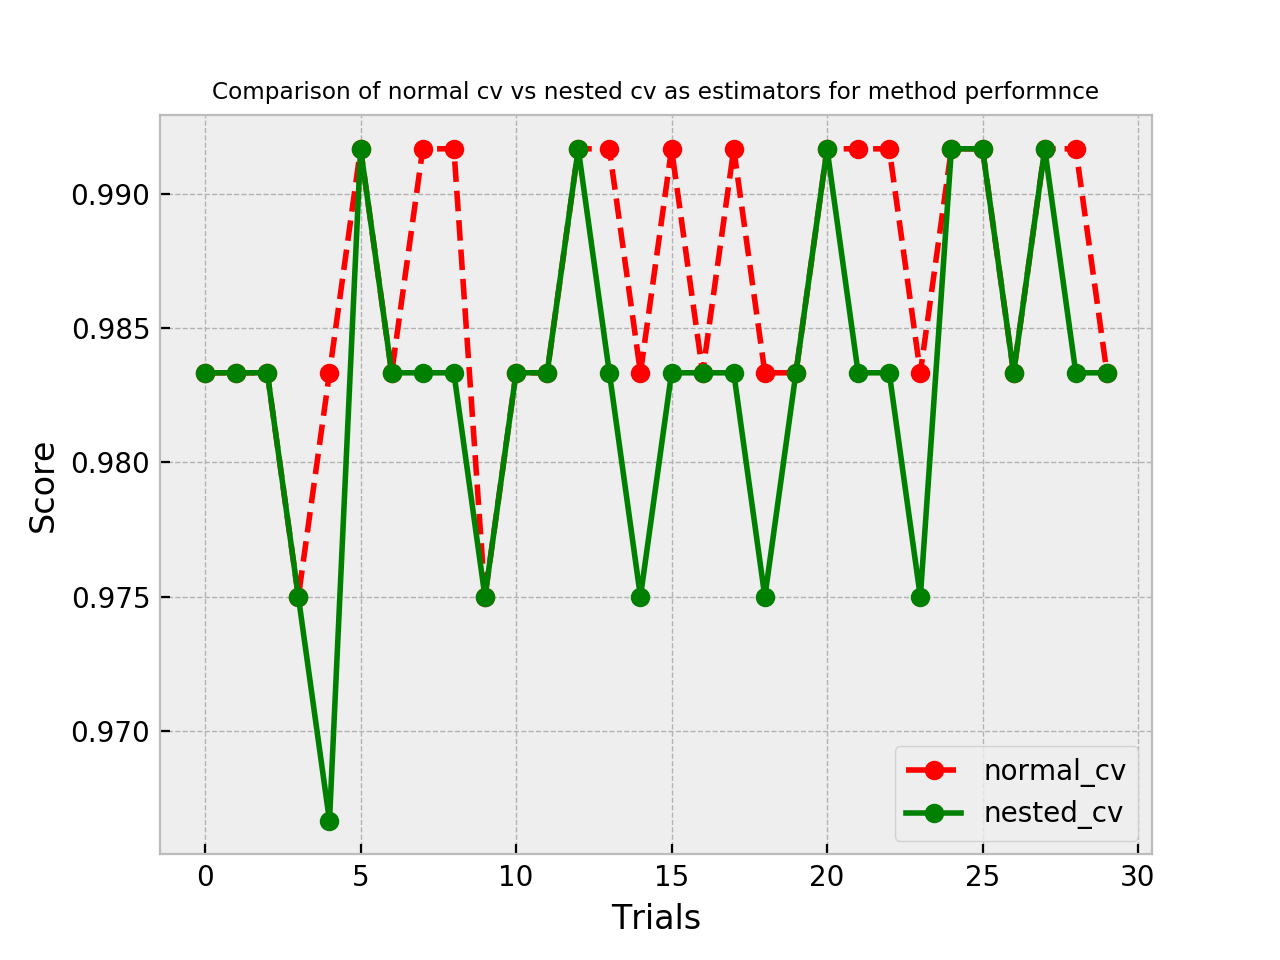

Text(0.5,1,'Comparison of normal cv vs nested cv as estimators for method performnce')

In [87]:
plt.figure()
plt.plot(range(30),perf_estimates, 'ro--', label = 'normal_cv')
plt.plot(range(30),perf_estimates_inner_cv, 'go-', label = 'nested_cv')
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Score')
plt.title('Comparison of normal cv vs nested cv as estimators for method performnce', 
          fontsize = 'small')